# <big><b> Using a Random Forest Classifier to identify flood days in southern Utah
</b></big>

This study aims to examine:
<ol> <li> What environmental paramters are most correlated with widespread flash flooding in southern Utah </li>
<li> If a model can incorporate these parameters and provide forecasters with a probabilistic tool to assess the flood threat and issue better flash flood watches </li></ol>

We can use an ensemble machine learning technique known as Random Forests to aid in both of these tasks.

For more information on random forests I actually recommend the <a href = "https://en.wikipedia.org/wiki/Random_forest">wikipedia article</a> as it is quite informative and gives links to more detailed literature on the method if you are stats-inclined. Another good article which shows that random forest classification performs well relative to the more well-known technique of logistic regression can be found <a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2264-5"> here</a>

For more information on the specific python module I use to implement the random forest in this notebook refer <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">here</a>

## Initial data analysis

Let's begin with examining the environmental dataset we will use for this demo which is the South-Central Utah dataset (coming from RAP BUFR sounding data for Page Arizona).

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('KPGA_clean.csv') #Read the data in using Pandas
#See how big the data frame is 
print 'The dataset has {} entries and {} variables'.format(df.shape[0], df.shape[1])
df.info() #Describe the variables in it

The dataset has 153 entries and 33 variables
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 33 columns):
Date               153 non-null object
Basins             153 non-null int64
MUCAPE             152 non-null float64
NCAPE              152 non-null float64
DCAPE              153 non-null float64
LCL                153 non-null float64
LFC                152 non-null float64
PW                 153 non-null float64
7-5LR              153 non-null float64
MeanRH             153 non-null float64
MeanMixR           153 non-null float64
WCD                128 non-null float64
SfcT               153 non-null float64
SfcTd              153 non-null float64
DD                 153 non-null int64
FZL_AGL            151 non-null float64
WC                 153 non-null int64
0-6km Shear Dir    153 non-null float64
0-6km Shear Mag    153 non-null float64
C Dn Dir           153 non-null float64
C Dn Mag           153 non-null float64
C Up Dir         

<b> We can see there are 153 entries with most of the 33 variables being numeric (integers or floats) There are also some nulls entries and one variable which is an object (a string) "Flood".

Let's look at the first  few rows <b/>

In [2]:
df.head(3)

,Date,Basins,MUCAPE,NCAPE,DCAPE,LCL,LFC,PW,7-5LR,MeanRH,...,SM Dir,SM Mag,BRN Shear,MW Dir,MW Mag,4-6km dir,4-6km mag,Month,Flood,Result
0,2010-07-20,2,739.0,0.09,1072.0,3010.0,3375.0,3.67,7.6,33.0,...,244.0,9.0,12.0,214.0,12.0,182.0,7.0,7,Widespread Flooding,1.0
1,2010-07-21,1,1897.0,0.18,590.0,1826.0,1983.0,4.19,6.8,49.0,...,256.0,14.0,12.6,226.0,18.0,173.0,13.0,7,Limited Flooding,NaN
2,2010-06-16,0,29.0,0.03,1568.0,4145.0,4747.0,1.12,8.3,16.0,...,251.0,34.0,75.5,221.0,46.0,186.0,27.0,6,No Flooding,0.0


In [3]:
#Look at some basic descriptive statistics of the numeric variables
print df.describe()
print '\n'
print df['Flood'].value_counts(normalize=True) #This is the syntax for describing a string

           Basins       MUCAPE       NCAPE       DCAPE          LCL  \
count  153.000000   152.000000  152.000000   153.00000   153.000000   
mean     1.751634   840.361842    0.101908  1022.24183  2239.934641   
std      1.552930   528.760822    0.047726   422.27956   915.497044   
min      0.000000   -80.000000    0.000000    90.00000   331.000000   
25%      1.000000   435.500000    0.070000   697.00000  1545.000000   
50%      1.000000   790.000000    0.100000  1058.00000  2298.000000   
75%      3.000000  1185.750000    0.140000  1333.00000  2940.000000   
max      6.000000  2205.000000    0.200000  2073.00000  4299.000000   

               LFC          PW       7-5LR      MeanRH    MeanMixR    ...      \
count   152.000000  153.000000  153.000000  153.000000  153.000000    ...       
mean   2481.638158    3.001765    6.788235   48.202614    9.695425    ...       
std    1058.354887    0.701090    0.854165   18.030077    2.091912    ...       
min    -999.000000    1.110000    4.

<b> Most of these variables are self-explanitory thermodynamic and kinematic variables (note "WC" stands for warm cloud depth and "DD" stands for Sfc. Dewpoint Depression).
"Result" is a binary variable which indicates if there was widespread flooding in south-central Utah that day (0 means no flooding, 1 means widespread (more than 2 Basins) flooding, and NA correspods to limited (1 Basin) flooding). "Flood" is a categorical variable where Widespread Flooding corresponds to 2+ Basins flooding, Limited Flooding corresponds to 1 Basin flooding, and No Flooding corresponds to 0 Basins flooded.


 Some of our predictor variables are highly correlated so we can often just include one or the other and have no effect on the result of the model. Below you can visualize the correlation matrix between variables...notice how most of the Kinematic and Thermodynamic variables have high correlations between each other and some variables such as LCL height and Mean RH have strong negative correlations (which is logical).

Consequently we can safely exclude some predictors from of the model for the sake of computational simplicity (note Random Forests only suffer from collinearity problems when correlations are extremely high so we don't worry about that). We did retain the highly correlated MUCAPE and NCAPE (Normalized CAPE) parameters as both of these parameters were found to be quite important in their own right.</b>

Populating the interactive namespace from numpy and matplotlib


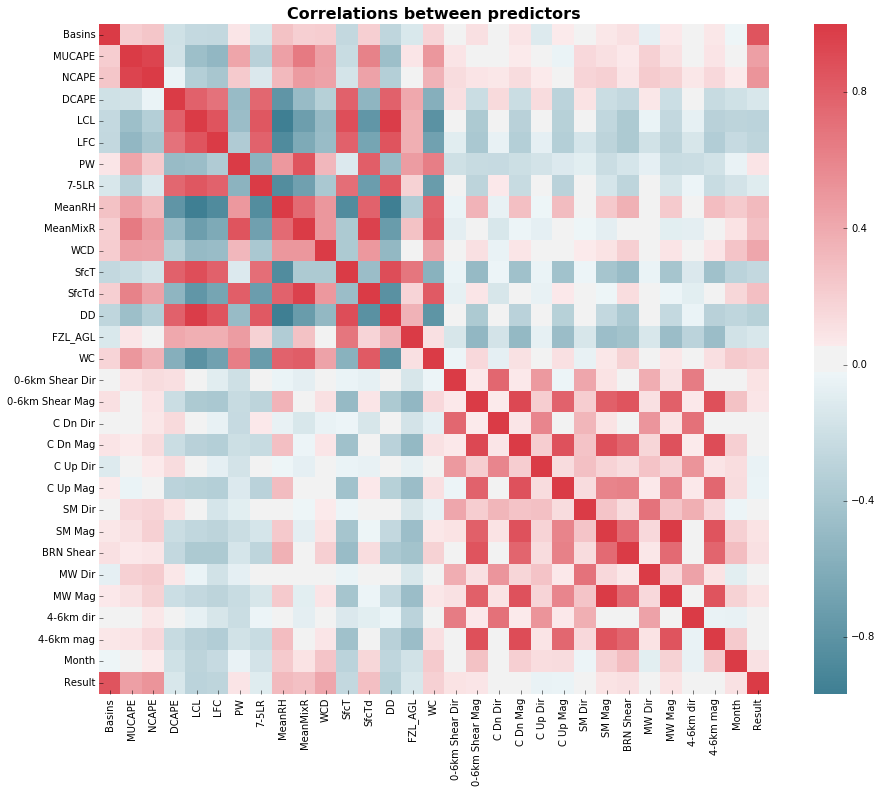

In [4]:
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlations between predictors', fontweight='bold', fontsize=16)
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [5]:
#These are the parameters we decided to retain
THERMO = ['MUCAPE', 'NCAPE', 'DCAPE', 'LCL',
          'PW', '7-5LR', 'MeanRH', 'SfcT', 'SfcTd',
          'DD', 'FZL_AGL', 'WC'] 
#Kinematic variables
KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir',
       'SM Mag', 'MW Dir', 'MW Mag']

<b> Now that we have seen the data going into the model let's run the model for Page (extendable to south-central Utah and drainages near Lake Powell) </b>

In [6]:
#Let's eliminate NAs in the relevant data since they can screw up the model
df.dropna(subset=[KIN + THERMO + ['Result'] ], inplace=True) 
predictors = df[THERMO + KIN] #Separate out the predictor variables
result = df['Result'] #Separate out the value we are trying to predict
print 'The dataset has {} entries to be included in model'.format(df.shape[0])

print 'There are {} major flood days and {} null days'.format(len(result[result == 1]), 
                                                              len(result[result == 0]))

The dataset has 93 entries to be included in model
There are 62 major flood days and 31 null days


<b> 93 entries may not seem like a large sample size, but the random forest, which is an ensemble technique that employs boostrapping for both feature selection and sample selection, can handle it as explained in the BMC article linked in the intro. 

Coincidentally we have half as many null cases as major flood days, which makes the dataset somewhat unbalanced. Later on if this seems to be causing classification problems we can weight the model to account for this by forcing it to select a higher proportion of null cases than random chance would suggest 

We are now ready to run the model </b>

 ## The Random Forest Model with sklearn

In [8]:
import sklearn.ensemble as ens
from sklearn.model_selection import train_test_split
from sklearn import metrics
#We first split the dataset into training and test datasets at a 70-30 ratio
xtrain, xtest, ytrain, ytest = train_test_split(predictors, 
                                                result, 
                                                test_size= 0.30) 

"""Let's create a random forest with 1000 trees but leave all other hyperparameters default to 
begin with """
clf = ens.RandomForestClassifier(n_estimators=1000)
#Fit the random forest using the training data
clf.fit(xtrain, ytrain)
#Predict the results using the test parameters as input
y_pred = clf.predict(xtest)
#How accurate was this prediction?
score = metrics.accuracy_score(ytest, y_pred)
#What were the most imporant features?
feature_imp = pd.Series(clf.feature_importances_,
                        index=predictors.columns).sort_values(ascending=False)

#Let's see the results!

print "The model accuracy is {:3.2f}".format(score)
print "The top 10 most important features are:"
for i in xrange(10):
    print '{}: {}'.format(i + 1, feature_imp.index[i])

The model accuracy is 0.79
The top 10 most important features are:
1: NCAPE
2: MUCAPE
3: 0-6km Shear Dir
4: FZL_AGL
5: C Up Mag
6: C Up Dir
7: SM Dir
8: MW Dir
9: MeanRH
10: C Dn Dir


## Interpreting results

<b>So we classify about 79 percent of the test cases correctly using the default hyperparameters with 1000 decision trees. This equates to 22/28 correct predicitions if you do the math based on a 70-30 test/train split of 93 events. However, since we have a relatively small amount of test cases this number can vary due to the randomness of the forest (e.g. sometimes we will get anywhere from 20-24 right) so focusing on this exact number is not wise at this step as it ranges from 71-86%. 

We don't have a great benchmark for what is a "good" classification accuracy in this context, since we used intentionally ambiguous null cases (e.g. high PW days) we might suspect it to be close to random chance. Whatever the case at the very least our classification score is better than random chance (which would be about 67% given our dataset makeup).

We can also see that the two (highly correlated) CAPE paramters are 1 and 2 in terms of importance, with a mix of thermodynamic and kinematic variables following. We can visualize quantitatively how important each feature below: </b>

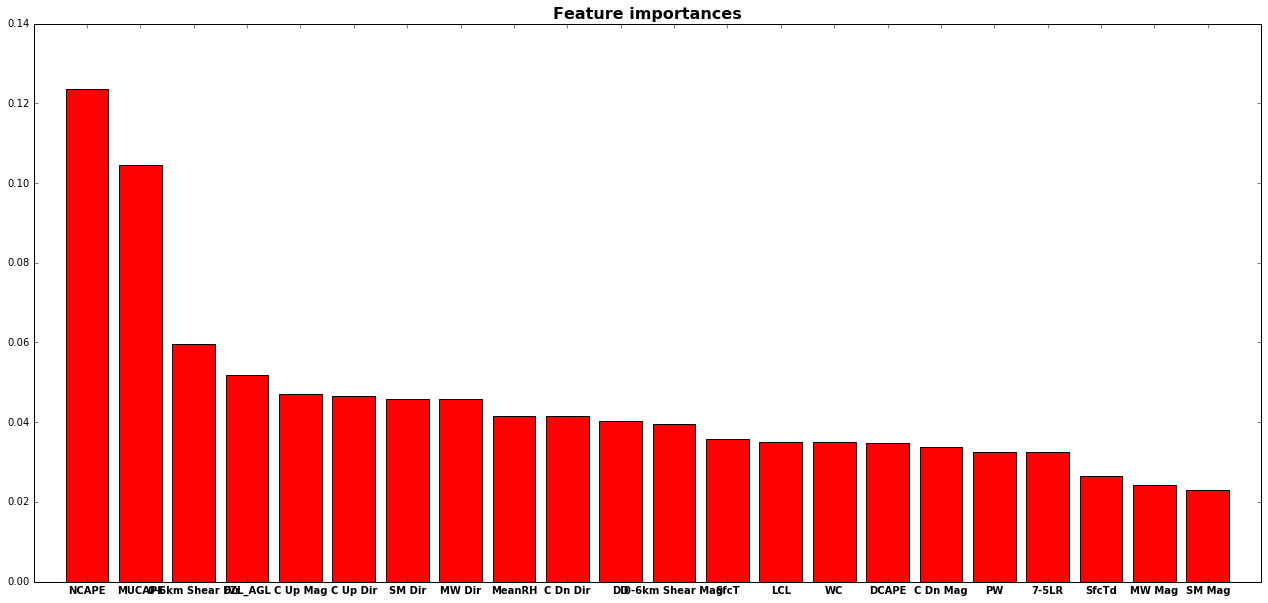

In [9]:
import numpy as np
labels = feature_imp.index.tolist()

indices = np.argsort(feature_imp)[::-1]
plt.figure(figsize=(22,10))
plt.title("Feature importances", fontweight='bold', fontsize=16)
plt.bar(range(predictors.shape[1]), feature_imp[indices],
       color="r", align="center")
#Apologies for the xaxis labels overlap but it is tricky to change
plt.xticks(range(predictors.shape[1]), labels, fontweight='bold')
plt.xlim([-1, predictors.shape[1]])

plt.show()

<b> It is obvious that NCAPE and MUCAPE  are head and shoulders above the other variables with many of the other other parameters having very similar importance scores (thus they will occasionally switch places in the rankings due to the randomness of the forest).

If we want we can visualize a single decision tree from the random forest to highlight the general process </b>

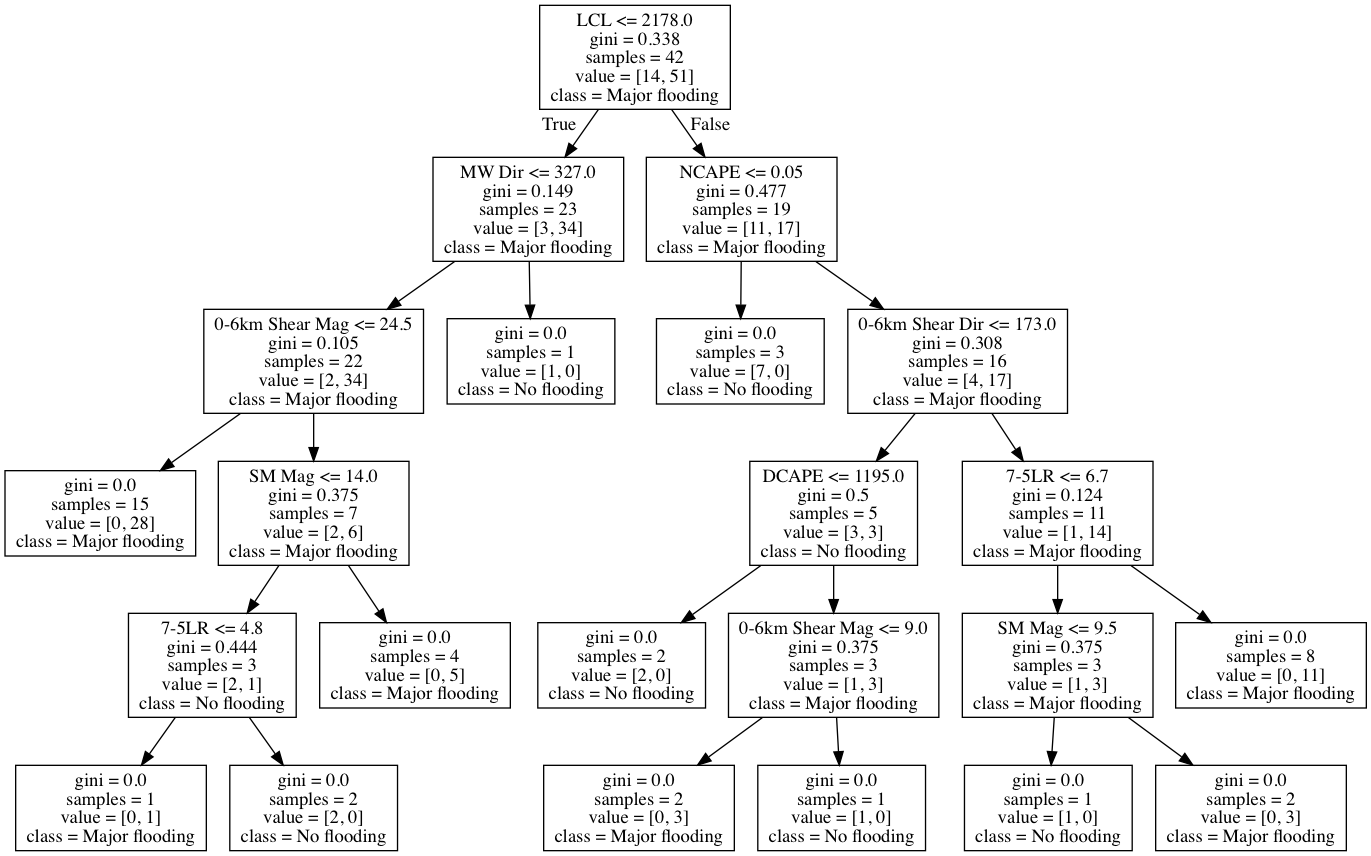

In [10]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
class_names = ['No flooding', 'Major flooding']
# Pull out one tree from the forest, the 13th one to be specific
tree = clf.estimators_[12]
# Some plotting magic
export_graphviz(tree, out_file = 'tree.dot', 
                feature_names = predictors.columns, class_names = class_names)
graph = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image('tree.png')

 <b> Note the Gini coefficient is essentially a measure of how effective a particular split is in splitting the data (ideally one class would be all on the right side of a split with the other on the left). We can see some of our splits have Gini coefficients of 0 with a very small number of samples making it to the split. These splits are basically useless and we can refine the model hyperparameters later on to improve on this.

Finally since this is an ensemble classification method we can get a probabilistic estimate by seeing what percentage of trees predicted a particular result (in this case flooding or no flooding) when given a vector of predictors. 

Note as mentioned earlier we consider 2+ Basins as widespread flooding and 0 Basins as no flooding. </b>

In [11]:
#Just look at the first 30 events for brevity
for i in xrange(30):
    noflood = clf.predict_proba([predictors.iloc[i]]) [0, 0]
    flood = clf.predict_proba([predictors.iloc[i]]) [0, 1]
    print 'Prob No Flood, Prob Flood, Basins flooded '
    print '{:3.2f},\t \t {:3.2f},\t \t{}'.format(noflood, flood, df.Basins.iloc[i])

Prob No Flood, Prob Flood, Basins flooded 
0.13,	 	 0.87,	 	2
Prob No Flood, Prob Flood, Basins flooded 
0.83,	 	 0.17,	 	0
Prob No Flood, Prob Flood, Basins flooded 
0.13,	 	 0.87,	 	2
Prob No Flood, Prob Flood, Basins flooded 
0.07,	 	 0.93,	 	6
Prob No Flood, Prob Flood, Basins flooded 
0.07,	 	 0.93,	 	3
Prob No Flood, Prob Flood, Basins flooded 
0.07,	 	 0.93,	 	2
Prob No Flood, Prob Flood, Basins flooded 
0.79,	 	 0.21,	 	0
Prob No Flood, Prob Flood, Basins flooded 
0.09,	 	 0.91,	 	3
Prob No Flood, Prob Flood, Basins flooded 
0.12,	 	 0.89,	 	3
Prob No Flood, Prob Flood, Basins flooded 
0.65,	 	 0.35,	 	0
Prob No Flood, Prob Flood, Basins flooded 
0.07,	 	 0.93,	 	4
Prob No Flood, Prob Flood, Basins flooded 
0.05,	 	 0.95,	 	4
Prob No Flood, Prob Flood, Basins flooded 
0.84,	 	 0.16,	 	0
Prob No Flood, Prob Flood, Basins flooded 
0.79,	 	 0.21,	 	0
Prob No Flood, Prob Flood, Basins flooded 
0.15,	 	 0.85,	 	2
Prob No Flood, Prob Flood, Basins flooded 
0.14,	 	 0.86,	 	3
Prob No 

<b> Additionally as we can employ the Brier Score to evaluate the classification since it spits out the probabilistic results </b>

In [12]:
yprob = clf.predict_proba(xtest)[0:, 1]
brier_score = metrics.brier_score_loss(ytest, yprob)
print 'The Brier Score {}'.format(brier_score)

The Brier Score 0.133424107143


<b> Recall the Brier Score ranges from 0 to 1 with 0 being a perfect probabilistic classifier and 1 measning no skill, a result of around .13 is pretty good (once again some error bars on this due to the small test size), although unfortunately there is no good reference score with which to calculate the Brier Skill score for this case </b>

<b>Finally the model is really easy to get back via Python's "pickle" module so we don't have to re-train it every time we want to get a prediction. That being said Random Forests are very computationally efficient and a 1000+ tree model can be run in seconds on most machines (also given that each tree is independent multi-processing is quite natural). </b>

In [13]:
import pickle
filename='Flood_model'
#Save it
pickle.dump(clf, open(filename, 'wb'))
#Load it back up
rf = pickle.load(open(filename, 'rb'))

## Summary and potential drawbacks

<b> Overall this does not seem like a poor result given that we didn't tune the hyperparameters yet still had a reasonably high classification accuracy and reasonably low Brier Score. One potential use once we get the model better calibrated and trained is to potentially replace SLC's Flash Flood Potential product with something like the forest probabilities being used to define the various classes (e.g. Probable 50-75%, Possible 25-50% etc.).


The biggest drawbacks are:
<ol> <li> We intentionally only used "borderline" null cases on this study i.e. we chose cases with PWATs > 90th climatological percentile, and days in which SLC issued Flash Flood watches but no flooding occurred. Consequently the model is not calibrated towards other types of events, in fact as you noticed from the feature importances Precipitable Water was apparently one of the least important variables however this is largely because of the fact that high PWAT values were intentionally present in a lot of our null cases. It would likely rise quite rapidly in importance if all warm-season days were considered </li>

<li>The environmental data came from the RAP BUFR soundings (2 hour forecasts to avoid model spinup issues). Therefore we would have to test out data from other mesoscale data sources (such as the NAM or its FV3-era successor) before implementing as a forecaster may want more than a 20 hour lead time when making flash flood watch decisions </li>

<li>The final drawback is that although the Random Forest is a fairly robust classifier it is mostly a black box. A common saying is Random Forests are focused on prediction rather than explanation because unlike for example logistic regression you don't get coefficients that can be relatively easily interpreted. Consequently you often have to use ancillary data to determine how parameters impact the result. For this particular example it is quite obvious (to a meteorologist at least) how the theromdyanmic variables would impact the result (higher MUCAPE =higher flood chance, higher MeanRH = higher flood chance), however interpreting the kinematic variables can be more difficult (e.g. does a storm motion of 240 have a greater flood risk than a storm motion of 310?). Data visualization tools like boxplots/violinplots are useful for these purposes (see below) </li> </ol>

</b>

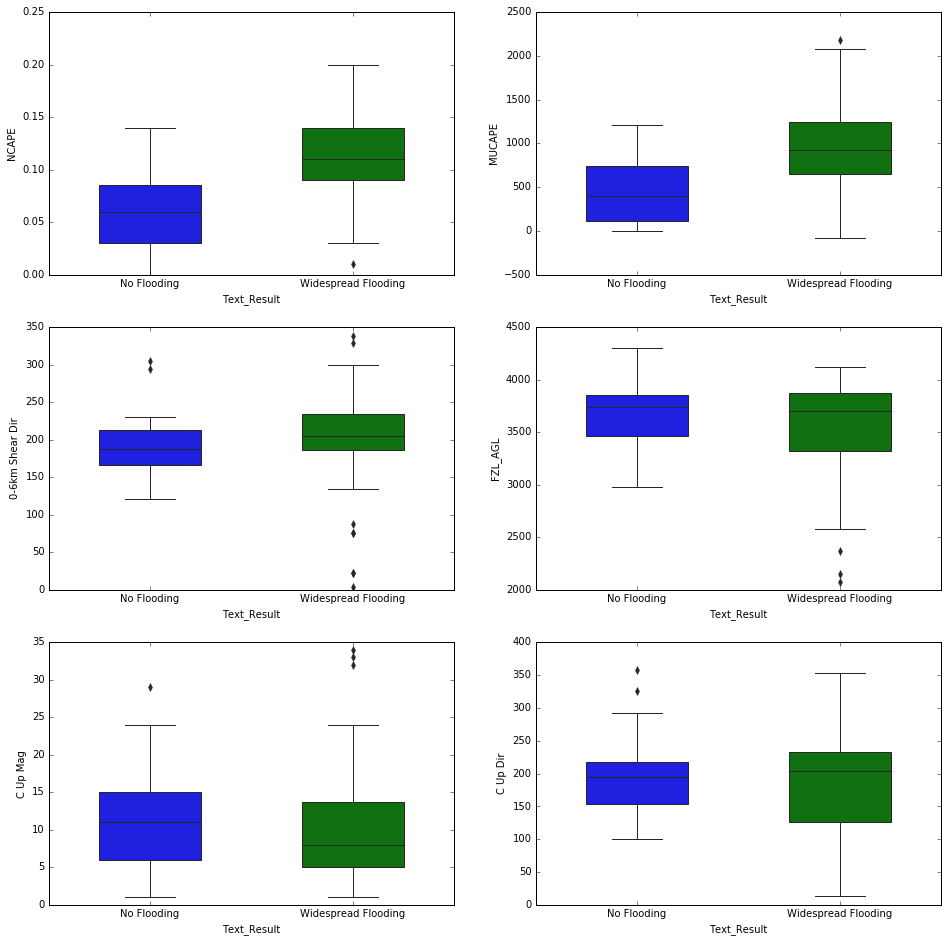

In [14]:
# Convert 1s and 0s to text to make x-axis more informative
df['Text_Result'] = np.nan
df.loc[(df.Result == 0), 'Text_Result'] = 'No Flooding'
df.loc[(df.Result == 1), 'Text_Result'] = 'Widespread Flooding'
fix, axes = plt.subplots (3, 2, figsize=(16,16))
axs = axes.ravel()

#Only plot 6 most important features
for i, feature in enumerate(feature_imp.index[:6]):
    boxplot = sns.boxplot(x='Text_Result', y=feature, data=df, width=0.5, 
                          order= ['No Flooding', 'Widespread Flooding'], ax=axs[i])

<b> We can see the CAPE variables have fairly obvious separation with generally lower mid-lvl freezing levels being preferred. Relationships start to become less significant with the other features but it seems like a more westerly shear component is somewhat favorable </b>

## Appendix: Hyperparameter Optimization (Tuning)

There are lots of hyperparameters that can be modified in sklearns random forest classifier, fortunately sklearn has a package that can be used to optimize these parameters for a given dataset 


In [15]:
from sklearn.model_selection import RandomizedSearchCV
"""We basically set how many possible parameter combinations we want to cycle through"""
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [16]:
clf = ens.RandomForestClassifier(n_estimators=size)
#This can take a while 
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(xtrain, ytrain)
best_params = rf_random.best_params_
print best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished
/Users/nicholascarr/anaconda/envs/flood/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 1008, 'max_features': 'auto', 'min_samples_split': 5, 'max_depth': 23}


In [17]:
#Let's plug these parameters in note Bootstrap=True, and max_features=sqrt are the defaults
clf = ens.RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                 max_depth=best_params['max_depth'], 
                                 min_samples_leaf=best_params['min_samples_leaf'], 
                                 min_samples_split=best_params['min_samples_split'])
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
score = metrics.accuracy_score(ytest, y_pred)
#Have we improved?
print "The model accuracy is {:3.2f}".format(score)
#Slightly!

The model accuracy is 0.82


## Looking at the other regions 

In [18]:
import glob

for csv in glob.glob("*clean.csv"):
    site_name = csv[:4]
    if site_name == 'KPGA':
        continue
    df = pd.read_csv(csv)
    df.dropna(subset=[KIN + THERMO + ['Result'] ], inplace=True) #Eliminate any NAs that snuck through
    predictors = df[THERMO + KIN]
    result = df['Result']
    print 'The dataset for {} has {} entries to be included in model'.format(site_name,
                                                                             df.shape[0])
    xtrain, xtest, ytrain, ytest = train_test_split(predictors, 
                                                    result, 
                                                    test_size= 0.30) 
    #Hyperparameters based on tuning
    clf = ens.RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=4)
    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    yprob = clf.predict_proba(xtest)[0:, 1]
    brier_score = metrics.brier_score_loss(ytest, yprob)
    score = metrics.accuracy_score(ytest, y_pred)
    feature_imp = pd.Series(clf.feature_importances_,
                            index=predictors.columns).sort_values(ascending=False)
    print "The model accuracy for {} is {:3.2f}".format(site_name, score)
    print "The brier score for {} is {:3.2f}".format(site_name, brier_score)
    print "The most important features for {} are".format(site_name)
  
    top = np.min([10, len(predictors.columns)])
    for i in xrange(top):
        print '{}: {}'.format(i + 1, feature_imp.index[i])
    print '\n'

The dataset for K4HV has 50 entries to be included in model
The model accuracy for K4HV is 0.87
The brier score for K4HV is 0.12
The most important features for K4HV are
1: NCAPE
2: MUCAPE
3: C Up Dir
4: SfcT
5: DD
6: SM Mag
7: MW Mag
8: C Dn Dir
9: LCL
10: 0-6km Shear Dir


The dataset for KBCE has 158 entries to be included in model
The model accuracy for KBCE is 0.75
The brier score for KBCE is 0.18
The most important features for KBCE are
1: MW Dir
2: 0-6km Shear Dir
3: MUCAPE
4: C Dn Dir
5: SM Dir
6: NCAPE
7: FZL_AGL
8: C Up Dir
9: DCAPE
10: LCL


The dataset for KSGU has 62 entries to be included in model
The model accuracy for KSGU is 0.74
The brier score for KSGU is 0.17
The most important features for KSGU are
1: NCAPE
2: MUCAPE
3: DCAPE
4: WC
5: LCL
6: MeanRH
7: C Dn Dir
8: SM Dir
9: MW Mag
10: FZL_AGL


